In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housesalesprediction/kc_house_data.csv


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


import warnings
warnings.filterwarnings('ignore')


In [60]:
def wrangle (filepath):
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    df['zipcode'] = df['zipcode'].astype(str)

    df = df[(df['price']>df['price'].quantile(0.025))&(df['price']<df['price'].quantile(0.975))]
    df.drop(['id'],axis=1,inplace=True)

    return df
    

In [61]:
df = wrangle('/kaggle/input/housesalesprediction/kc_house_data.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


### Data Exploration and Visualization

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20503 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20503 non-null  datetime64[ns]
 1   price          20503 non-null  float64       
 2   bedrooms       20503 non-null  int64         
 3   bathrooms      20503 non-null  float64       
 4   sqft_living    20503 non-null  int64         
 5   sqft_lot       20503 non-null  int64         
 6   floors         20503 non-null  float64       
 7   waterfront     20503 non-null  int64         
 8   view           20503 non-null  int64         
 9   condition      20503 non-null  int64         
 10  grade          20503 non-null  int64         
 11  sqft_above     20503 non-null  int64         
 12  sqft_basement  20503 non-null  int64         
 13  yr_built       20503 non-null  int64         
 14  yr_renovated   20503 non-null  int64         
 15  zipcode        2050

In [63]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.050300e+04,20503.000000,20503.000000,20503.000000,2.050300e+04,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000,20503.000000
mean,5.094753e+05,3.368580,2.103485,2045.411159,1.486021e+04,1.495318,0.004097,0.204165,3.411013,7.626347,1761.004536,284.406623,1971.370190,79.626689,47.562189,-122.212972,1969.443447,12606.854509
std,2.421977e+05,0.915449,0.721857,816.056423,4.039555e+04,0.539917,0.063878,0.702830,0.646060,1.076356,759.943946,425.142066,29.334827,390.637878,0.138819,0.141285,644.375233,26606.736445
min,1.858500e+05,0.000000,0.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.280000e+05,3.000000,1.750000,1440.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,47.473000,-122.330000,1500.000000,5040.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.544000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1976.000000,0.000000,47.573700,-122.229000,1840.000000,7560.000000
75%,6.300000e+05,4.000000,2.500000,2510.000000,1.048850e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2180.000000,550.000000,1997.000000,0.000000,47.680400,-122.122000,2330.000000,10000.000000
max,1.484900e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,7320.000000,2850.000000,2015.000000,2015.000000,47.777600,-121.319000,5790.000000,871200.000000


In [64]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.
There are 19 house features plus the price and the id columns, along with 21613 observations.
No missing values.

In [65]:
df.describe(include='O')

,zipcode
count,20503
unique,70
top,98103
freq,599


### Explore the data

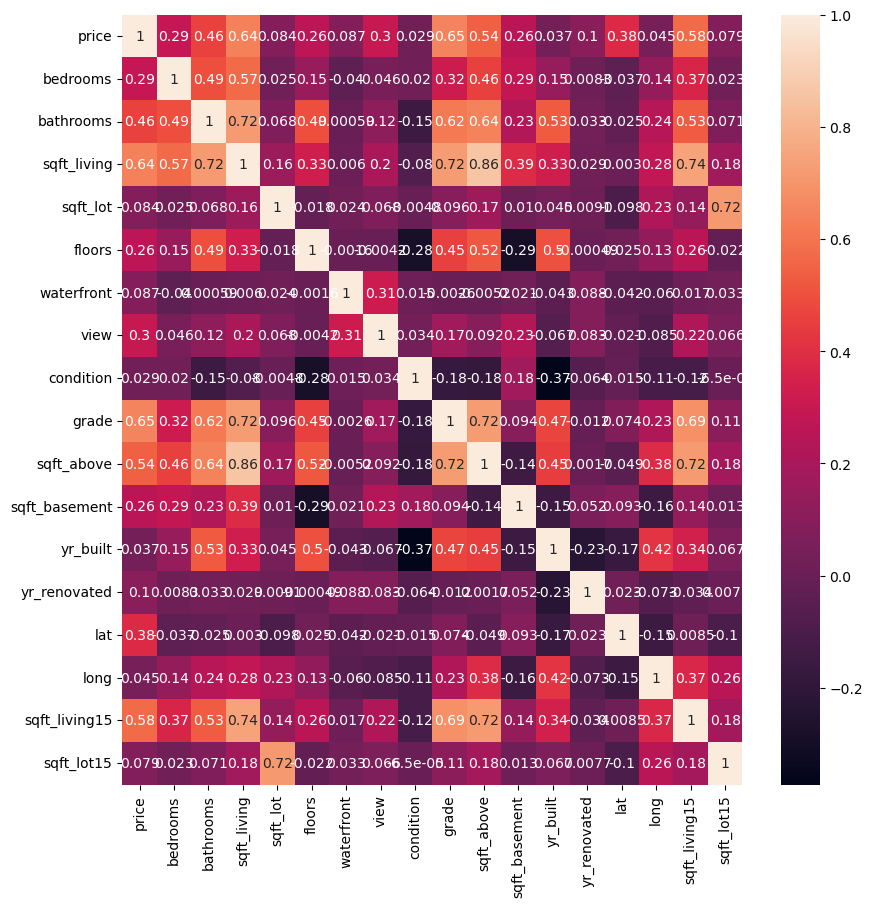

In [66]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()

In [67]:
df.nunique()

date              372
price            3550
bedrooms           13
bathrooms          27
sqft_living       933
sqft_lot         9407
floors              6
waterfront          2
view                5
condition           5
grade              10
sqft_above        870
sqft_basement     284
yr_built          116
yr_renovated       70
zipcode            70
lat              4988
long              745
sqft_living15     746
sqft_lot15       8324
dtype: int64

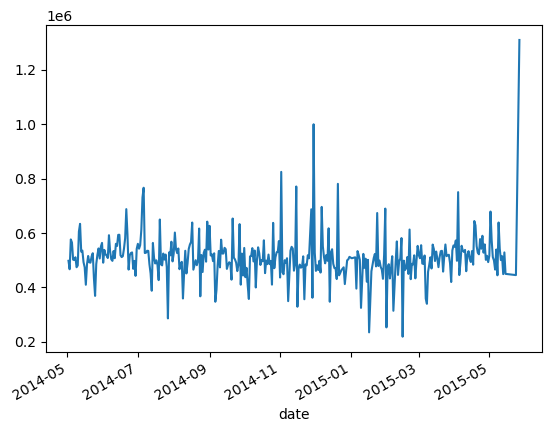

In [68]:
df.groupby('date')['price'].mean().plot()
plt.show()

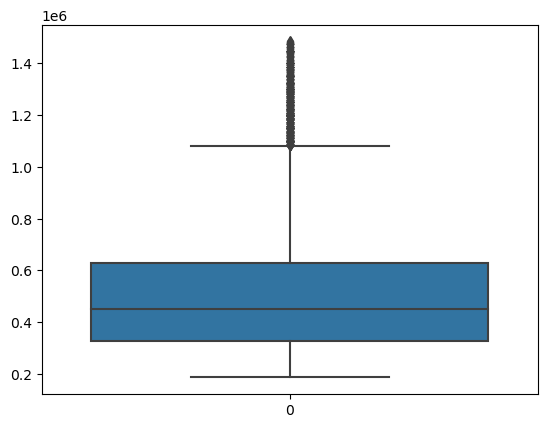

In [69]:
sns.boxplot(df['price'])
plt.show()

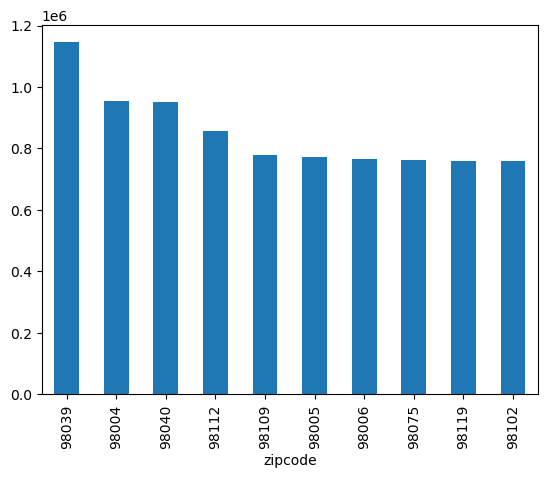

In [70]:
df.groupby('zipcode')['price'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

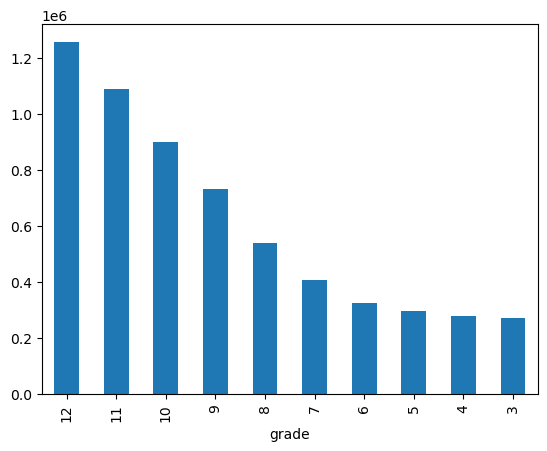

In [71]:
df.groupby('grade')['price'].mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

This is normal as the the grade means the construction quality of improvements. Grades run from grade 1 to 13. 


The price is skewed to the left. This is normal as very expensive houses are a small proportion of the total.

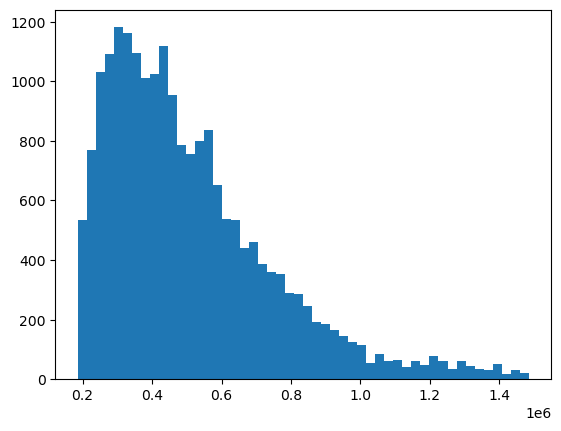

In [72]:
plt.hist(df['price'], bins=50)
plt.show()

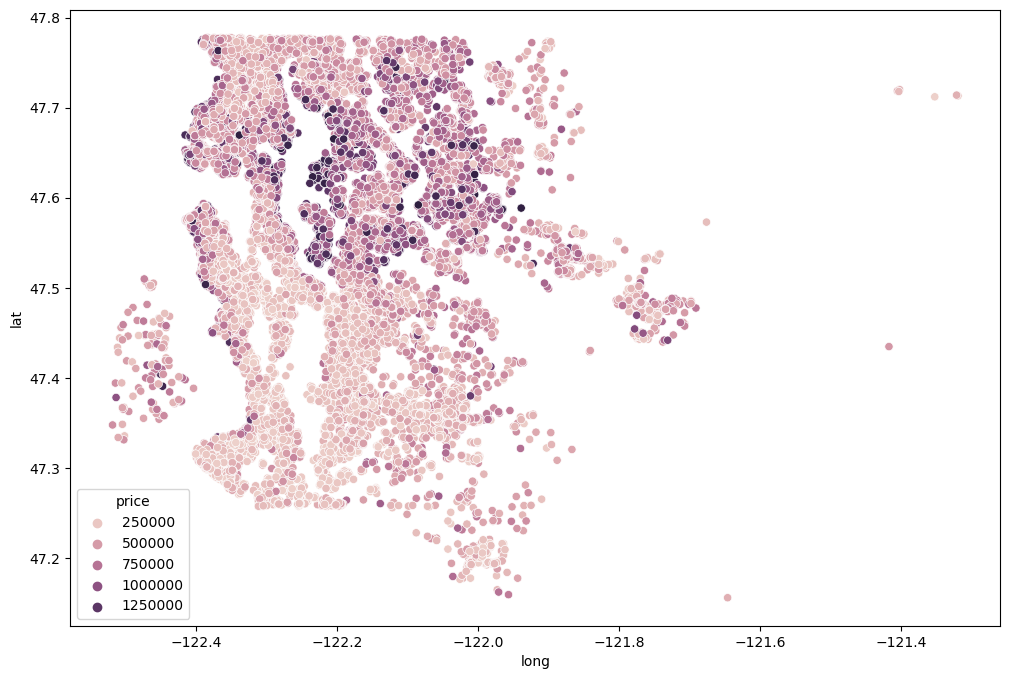

In [73]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', data=df, hue='price')
plt.show()

In this section, we continue to visualize the data with additional plots.

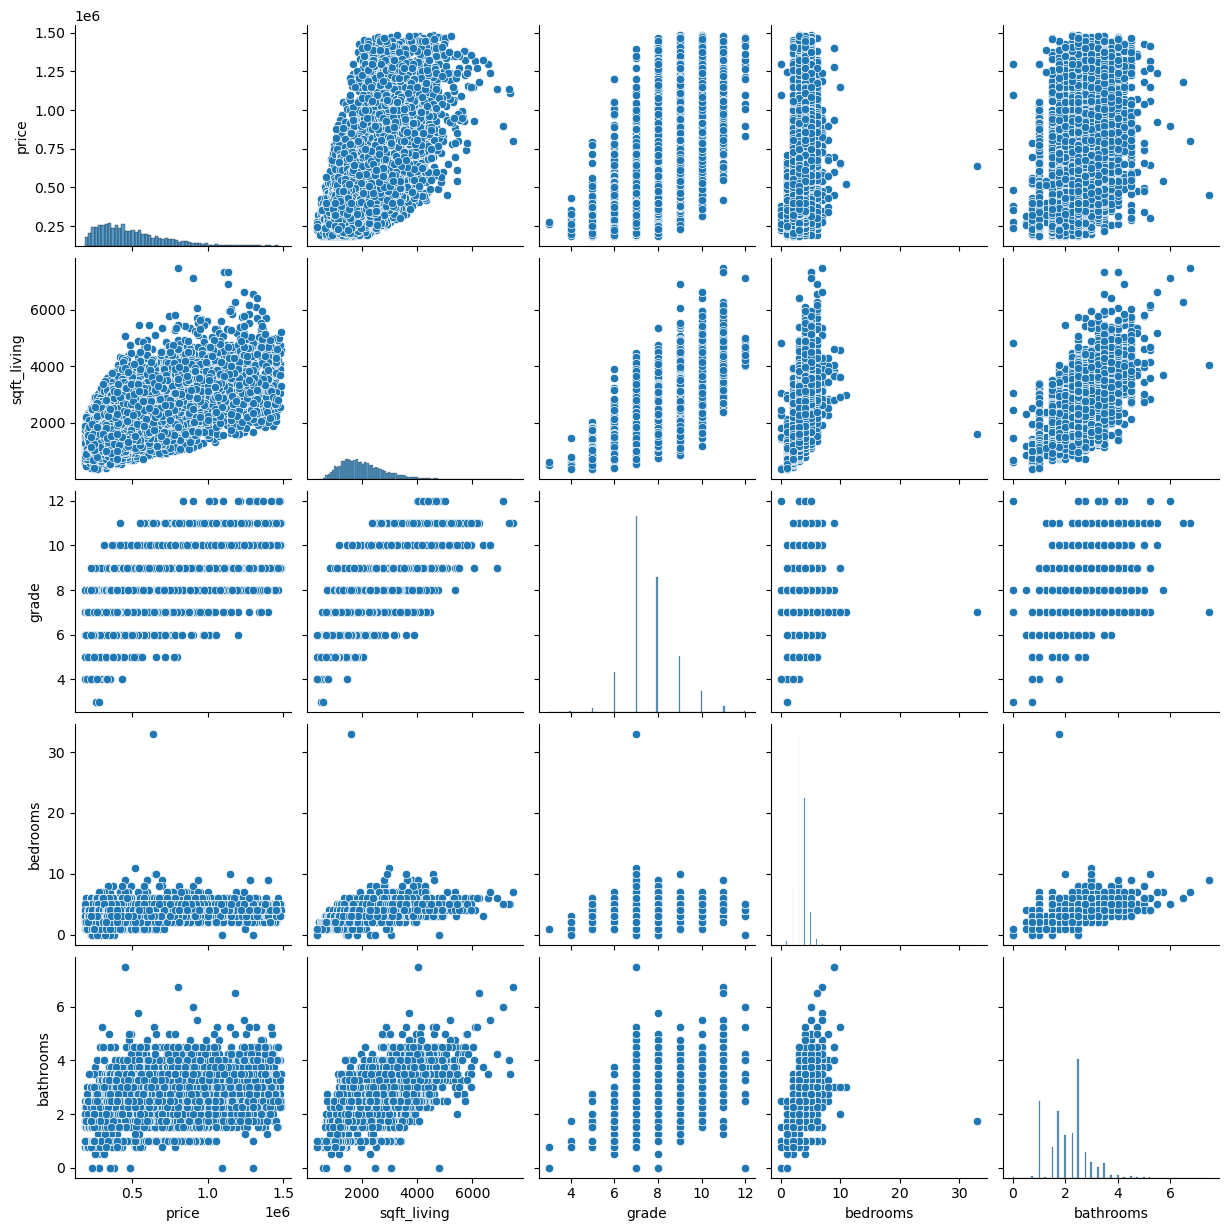

In [74]:
selected_features = ['price', 'sqft_living', 'grade', 'bedrooms', 'bathrooms']
sns.pairplot(df[selected_features])
plt.show()

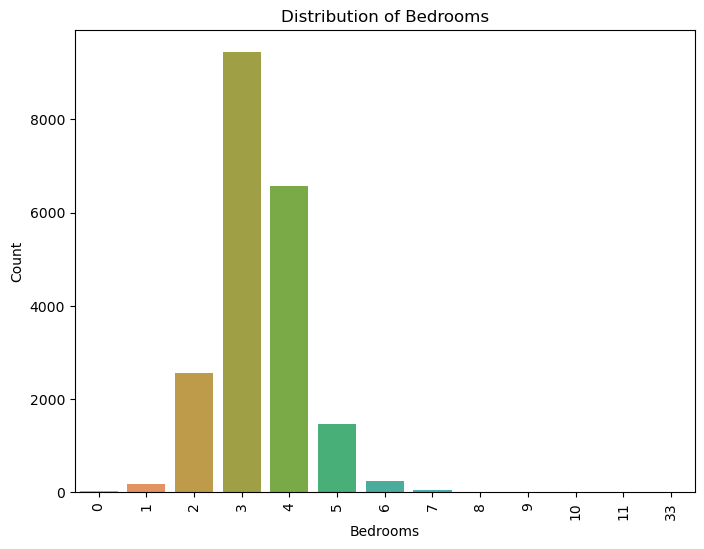

In [75]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='bedrooms')
plt.title('Distribution of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

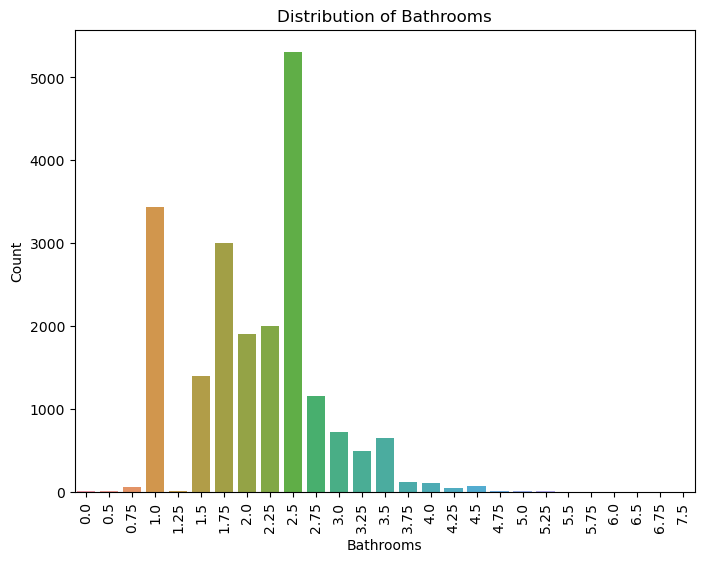

In [76]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='bathrooms')
plt.title('Distribution of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

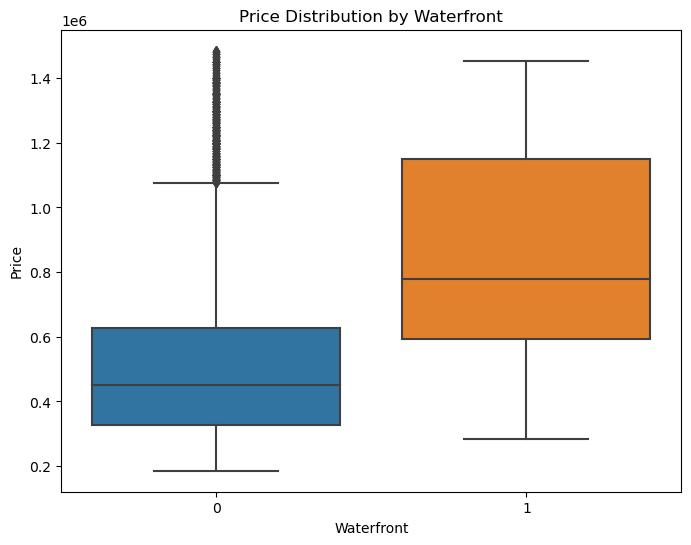

In [77]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='waterfront', y='price')
plt.title('Price Distribution by Waterfront')
plt.xlabel('Waterfront')
plt.ylabel('Price')
plt.show()

### Data Modeling

#### Split the data into training and testing sets

In [78]:
target = 'price'
X = df.drop(columns=[target,'date'])
y = df[target]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(15377, 18) (5126, 18) (15377,) (5126,)


## Linear Regression Model

In [80]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))    

RMSE: 132068.20051980185
R2: 0.697518410174748


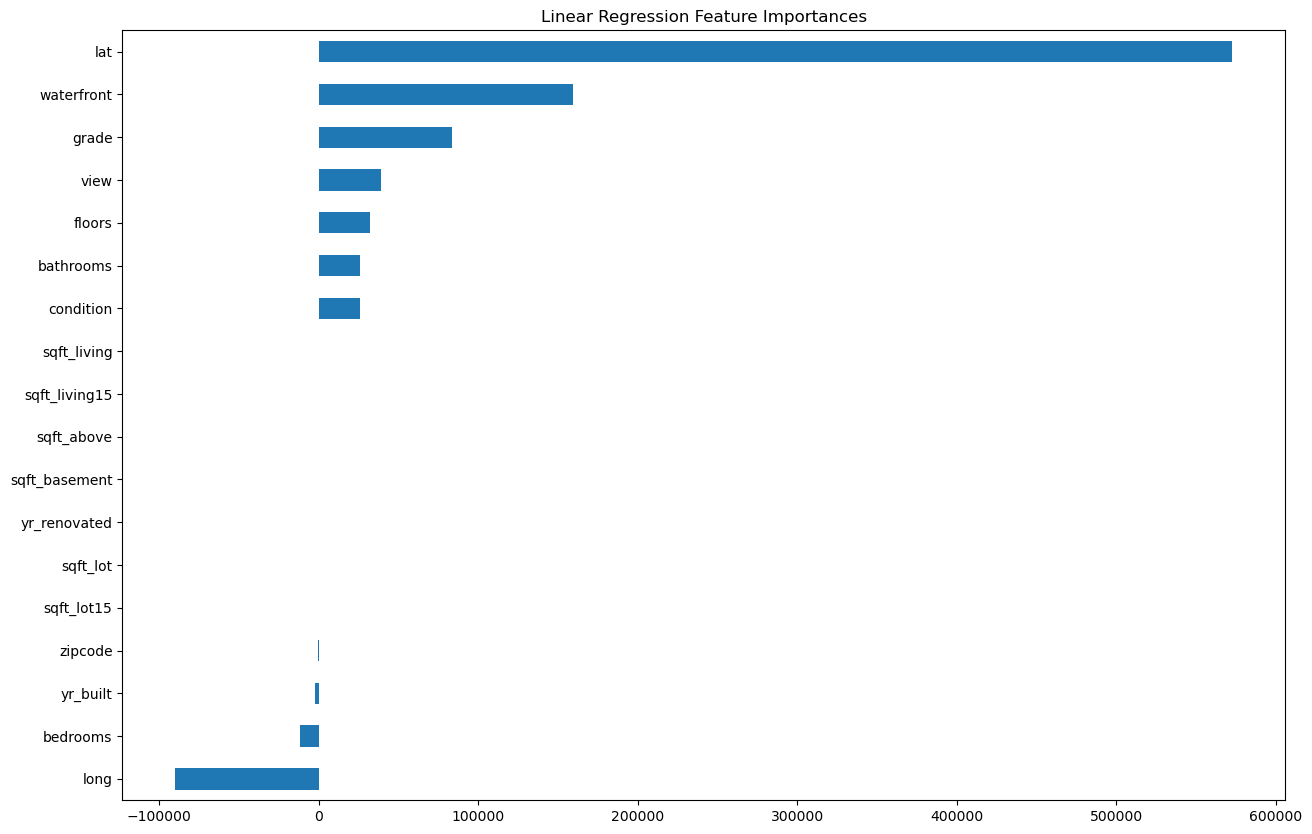

In [81]:
features = X_train.columns
coefs = lr.coef_
plt.figure(figsize=(15, 10))
pd.Series(coefs, features).sort_values().plot.barh()
plt.title('Linear Regression Feature Importances')
plt.show()

#### Random Forest Regression Model

In [82]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Random Forest Results:')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

Random Forest Results:
RMSE: 89876.92653190164
R2: 0.8599126720805546


#### Decision Tree Regression Model

In [83]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('Decision Tree Results:')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

Decision Tree Results:
RMSE: 128286.019345243
R2: 0.7145953235695677


### Using pipelines

In [84]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

In [85]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print('Pipeline (StandardScaler + Random Forest) Results:')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

Pipeline (StandardScaler + Random Forest) Results:
RMSE: 89836.9562603704
R2: 0.8600372442856348


In [86]:
params = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [5, 10, 15, 20]
}

In [87]:
cv = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [89]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [5, 10, 15, 20],
                         'randomforestregressor__n_estimators': [100, 200,
                                                                 300]},
             verbose=1)

In [93]:
cv.best_params_

{'randomforestregressor__max_depth': 20,
 'randomforestregressor__n_estimators': 300}

In [ ]:
cv.best_score_

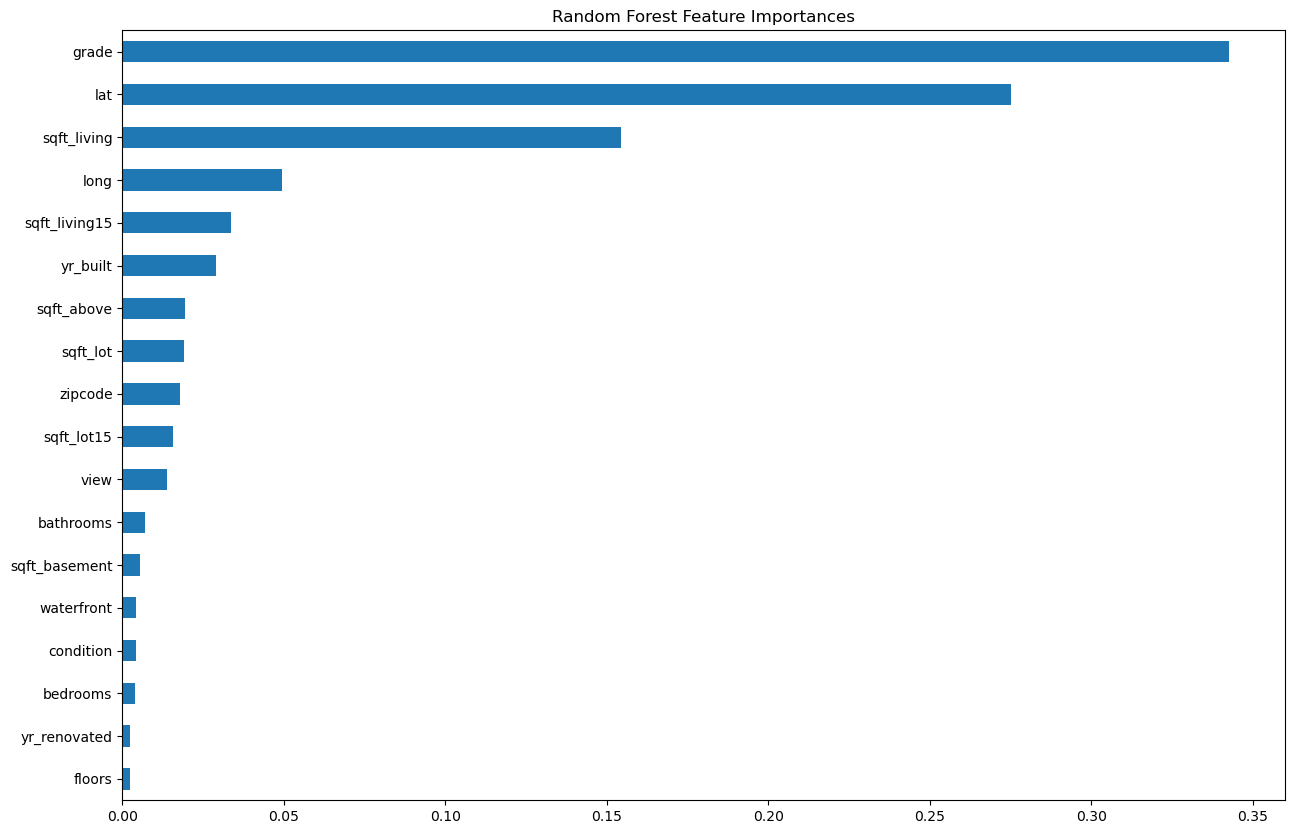

In [96]:
feature_importances = cv.best_estimator_.named_steps['randomforestregressor'].feature_importances_
plt.figure(figsize=(15, 10))
pd.Series(feature_importances, X_train.columns).sort_values().plot.barh()
plt.title('Random Forest Feature Importances')
plt.show()

In [97]:
def make_prediction (bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15):
    df = pd.DataFrame(
        columns=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
        data=[[bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]]
    )
    y_pred = f"The price is ${cv.predict(df)[0]}"
    return y_pred

In [95]:
prediction = make_prediction(3, 2, 2000, 10000, 1, 0, 0, 3, 7, 1000, 1000, 1990, 0, '98001', 47.0, -122.0, 2000, 10000)
print(prediction)

The price is $293863.7523015873
